In [1]:
import os, sys
sys.path.append('/data/spark15/python/')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 9)
import seaborn as sb
import numpy as np
import pandas as pd

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import HiveContext
from pyspark.sql.types import *
import pyspark.sql.functions

sc = SparkContext("local", "hospital_compare")
sqlContext = SQLContext(sc)
hc = HiveContext(sc)

In [3]:
print(hc.tableNames())

[u'effective_care', u'effective_care_scores', u'hospitals', u'hospitals_reduced', u'measures', u'readmissions', u'readmissions_reduced', u'survey_responses', u'survey_responses_reduced']


### Are average scores for hospital quality or procedural variability correlated with patient survey responses?

In [4]:
hospitals = hc.sql('select * from hospitals_reduced').toPandas()
effective_care = hc.sql('select * from effective_care_scores').toPandas()
survey_responses = hc.sql('select * from survey_responses_reduced').toPandas()

In [5]:
survey_responses.head()

,provider_number,hospital_name,address,city,state,zip_code,county_name,communication_with_nurses_floor,communication_with_nurses_achievement_threshold,communication_with_nurses_benchmark,...,overall_rating_of_hospital_floor,overall_rating_of_hospital_achievement_threshold,overall_rating_of_hospital_benchmark,overall_rating_of_hospital_baseline_rate,overall_rating_of_hospital_performance_rate,overall_rating_of_hospital_achievement_points,overall_rating_of_hospital_improvement_points,overall_rating_of_hospital_dimension_score,hcahps_base_score,hcahps_consistency_score
0,450097,BAYSHORE MEDICAL CENTER,4000 SPENCER HWY,Pasadena,TX,77504,HARRIS,58.14,78.19,86.61,...,35.99,70.02,84.60,61.52,61.36,0 out of 10,0 out of 9,0,0,12
1,150023,UNION HOSPITAL INC,1606 N SEVENTH ST,Terre Haute,IN,47804,VIGO,58.14,78.19,86.61,...,35.99,70.02,84.60,74.99,75.16,4 out of 10,0 out of 9,4,24,14
2,050742,OLYMPIA MEDICAL CENTER,5900 WEST OLYMPIC BOULEVARD,Los Angeles,CA,90036,LOS ANGELES,58.14,78.19,86.61,...,35.99,70.02,84.60,64.76,58.25,0 out of 10,0 out of 9,0,0,6
3,150182,FRANCISCAN HEALTH CARMEL,12188 B NORTH MERIDIAN STREET,Carmel,IN,46240,HAMILTON,58.14,78.19,86.61,...,35.99,70.02,84.60,Not Available,85.75,10 out of 10,Not Available,10,76,20
4,180064,SAINT JOSEPH MOUNT STERLING,225 FALCON DRIVE,Mount Sterling,KY,40353,MONTGOMERY,58.14,78.19,86.61,...,35.99,70.02,84.60,75.88,70.91,1 out of 10,0 out of 9,1,29,18


### From previous two questions: functions that return overall hospital rating and hospital procedure variability

In [50]:
def hospital_variability():
    df = pd.merge(hospitals, effective_care, how='inner', left_on='provider_id', right_on='provider_id')
    results = df.set_index(['provider_id', 'hospital_name', 'measure_id'])[['score']].unstack()
    results = results.apply(pd.to_numeric)
    results = results.std(axis=1).reset_index().rename(columns={0:'StDev Procedures'})
    return results

def best_hospital_overall():
    df = pd.merge(hospitals, effective_care, how='inner', left_on='provider_id', right_on='provider_id') # merge effective_care_scores and hospitals_reduced
    df['hospital_overall_rating'] = df['hospital_overall_rating'].replace('Not Available', np.nan).apply(pd.to_numeric) # replace string values with numeric and
    return df

In [51]:
variability = hospital_variability()
hospital_rating = best_hospital_overall()

In [78]:
hospital_rating.head()

,provider_id,hospital_name,city,state,zip_code,county_name,hospital_type,hospital_ownership,meets_criteria,hospital_overall_rating,...,readmission_national_comparison,patient_experience_national_comparison,effectiveness_of_care_national_comparison,timeliness_of_care_national_comparison,measure_id,measure_name,condition,measure_start_date,measure_end_date,score
0,010001,SOUTHEAST ALABAMA MEDICAL CENTER,DOTHAN,AL,36301,HOUSTON,Acute Care Hospitals,Government - Hospital District or Authority,Y,3.0,...,Same as the national average,Below the national average,Same as the national average,Same as the national average,ED_1b,ED1,Emergency Department,01/01/2016,12/31/2016,None
1,010001,SOUTHEAST ALABAMA MEDICAL CENTER,DOTHAN,AL,36301,HOUSTON,Acute Care Hospitals,Government - Hospital District or Authority,Y,3.0,...,Same as the national average,Below the national average,Same as the national average,Same as the national average,ED_2b,ED2,Emergency Department,01/01/2016,12/31/2016,None
2,010001,SOUTHEAST ALABAMA MEDICAL CENTER,DOTHAN,AL,36301,HOUSTON,Acute Care Hospitals,Government - Hospital District or Authority,Y,3.0,...,Same as the national average,Below the national average,Same as the national average,Same as the national average,IMM_2,Immunization for influenza,Preventive Care,10/01/2015,03/31/2016,None
3,010001,SOUTHEAST ALABAMA MEDICAL CENTER,DOTHAN,AL,36301,HOUSTON,Acute Care Hospitals,Government - Hospital District or Authority,Y,3.0,...,Same as the national average,Below the national average,Same as the national average,Same as the national average,IMM_3_OP_27_FAC_ADHPCT,Healthcare workers given influenza vaccination,Preventive Care,10/01/2016,03/31/2017,None
4,010001,SOUTHEAST ALABAMA MEDICAL CENTER,DOTHAN,AL,36301,HOUSTON,Acute Care Hospitals,Government - Hospital District or Authority,Y,3.0,...,Same as the national average,Below the national average,Same as the national average,Same as the national average,OP_18b,OP 18,Emergency Department,01/01/2016,12/31/2016,None


In [79]:
variability.head()

,provider_id,hospital_name,StDev Procedures
0,010001,SOUTHEAST ALABAMA MEDICAL CENTER,2.886751
1,010005,MARSHALL MEDICAL CENTER SOUTH,0.000000
2,010006,ELIZA COFFEE MEMORIAL HOSPITAL,0.577350
3,010007,MIZELL MEMORIAL HOSPITAL,3.304038
4,010008,CRENSHAW COMMUNITY HOSPITAL,3.535534


In [12]:
## creating numeric columns from survey_response_reduced table and examining the overall rating of hospital performance
## in survey responses

(survey_responses['overall_rating_of_hospital_performance_rate'] = 
 survey_responses['overall_rating_of_hospital_performance_rate'].replace('Not Available', np.nan)
                                                                .apply(pd.to_numeric))

survey_responses = survey_responses.rename(columns={'provider_number': 'provider_id'})

In [63]:
## merging with hospital_rating_reduced table

df = pd.merge(survey_responses[['provider_id','overall_rating_of_hospital_performance_rate']], 
              hospital_rating[['provider_id','hospital_overall_rating']], on='provider_id')

In [86]:
## merging with effective_care_scores table

results = pd.merge(df, variability, on='provider_id')

### Examing Hospital Overall Rating vs. Patient Survey Responses

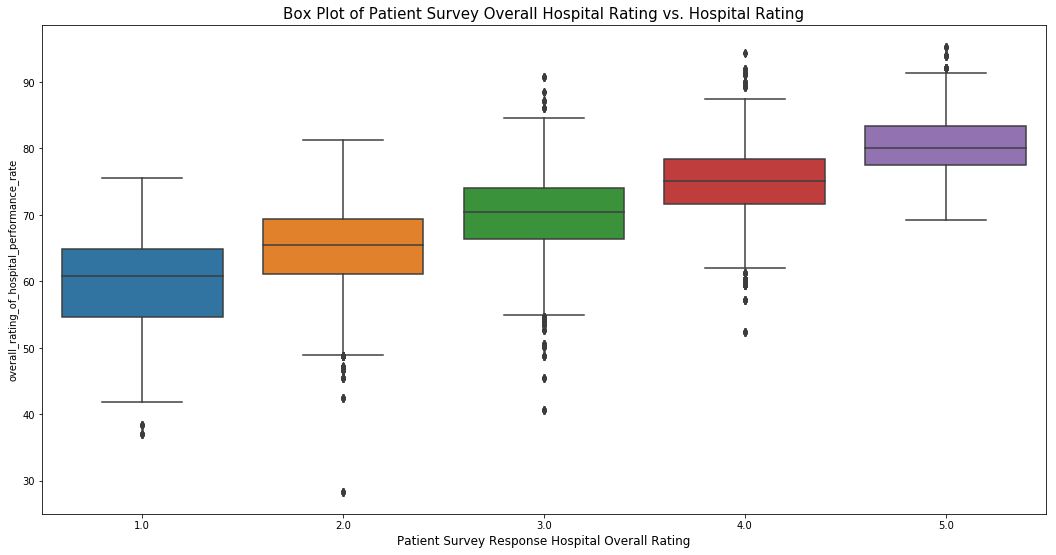

In [89]:
sb.boxplot(y=results['overall_rating_of_hospital_performance_rate'], x=results['hospital_overall_rating']);
plt.title('Box Plot of Patient Survey Overall Hospital Rating vs. Hospital Rating', fontsize=15);
plt.xlabel('Hospital Rating', fontsize=12);
plt.xlabel('Patient Survey Response Hospital Overall Rating', fontsize=12);

As we can see in the above boxplot, it appears that there is a correlation between patient survey responses regarding overall hospital performance vs. the actual hospital overall ratings

### Examining Procedure Variability vs. Patient Survey Resonses

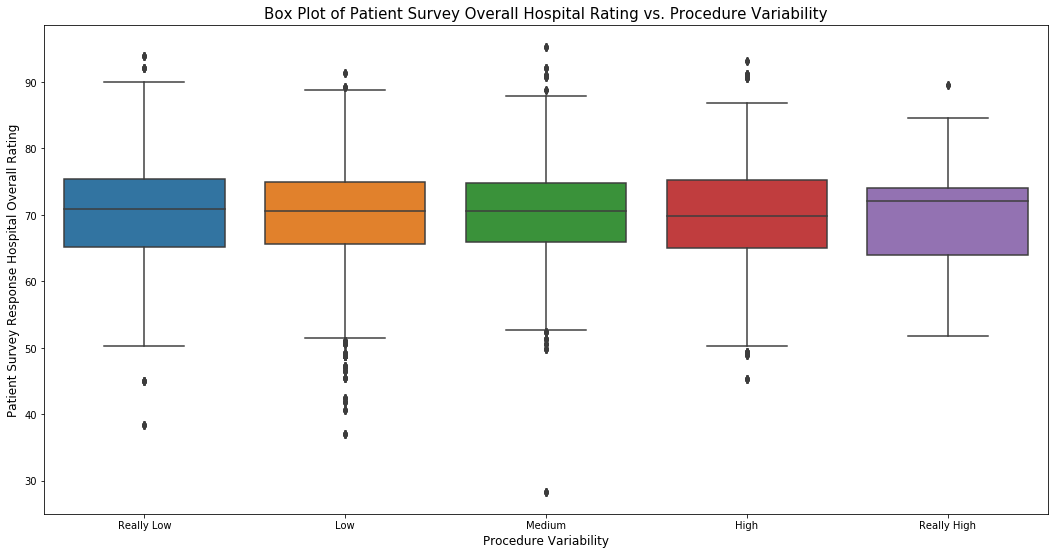

In [88]:
## First we'll bin the standard deviation in procedure measurements into 5 buckets: 'Really Low', 'Low', 'Medium',
##                                                                                  'High', 'Really High'

results['Procedure_Variability'] = pd.cut(results['StDev Procedures'], 5, labels=['Really Low', 'Low' ,
                                                                                  'Medium', 'High', 'Really High'])

## Boxplot Showing results
sb.boxplot(y=results['overall_rating_of_hospital_performance_rate'], x=results['Procedure_Variability']);
plt.title('Box Plot of Patient Survey Overall Hospital Rating vs. Procedure Variability', fontsize=15);
plt.xlabel('Procedure Variability', fontsize=12);
plt.ylabel('Patient Survey Response Hospital Overall Rating', fontsize=12);

The above boxplot shows almost no correlation between procedure variability as measured by the effective care table and patient survey responses on overall hospital rating

In [101]:
## calculating the correlations
print 'correlation between patient survey overall rating and hospital overall rating is '
print np.round(results['overall_rating_of_hospital_performance_rate'].corr(results['hospital_overall_rating']), 2)

print '\n'
print 'correlation between patient survey overall rating and hospital procedure variability is '
print np.round(results['overall_rating_of_hospital_performance_rate'].corr(results['StDev Procedures']), 2)

correlation between patient survey overall rating and hospital overall rating is 
0.58


correlation between patient survey overall rating and hospital procedure variability is 
0.01
